In [1]:
import pandas as pd 

In [2]:
# Lê 'Relatório de Compras.excel.csv' e mostra as primeiras 5 linhas
from pathlib import Path

try:
    import pandas as pd
except ImportError:
    raise ImportError("Pandas não encontrado. Instale com: pip install pandas")

file = Path("Relatório de Compras.excel.csv")
if not file.exists():
    raise FileNotFoundError(f"Arquivo não encontrado: {file.resolve()}")

# Tenta detectar separador automaticamente; se falhar, tenta ';' com encoding latin1
try:
    df = pd.read_csv(file, sep=None, engine='python', encoding='utf-8')
except Exception:
    df = pd.read_csv(file, sep=';', engine='python', encoding='latin1')

print(df.head(5))

   ﻿venda_id  data_venda         cliente estado canal_venda metodo_pagamento  \
0          1  23/10/2025    Rafael Gomes     CE        Site          Credito   
1          2  02/12/2025   William Rocha     BA        Site           Debito   
2          3  10/08/2025  Karen Teixeira     SP        Site              Pix   
3          4  01/11/2025   Daniel Araujo     SC        Site           Boleto   
4          5  14/07/2025   Eduardo Costa     MG        Site          Credito   

   valor_pago     status  
0     2989.03       Pago  
1      353.97  Cancelado  
2     2286.16   Pendente  
3     4073.37  Cancelado  
4     1163.25  Cancelado  


In [3]:
# Calcula faturamento total por estado
# Detecta automaticamente as colunas de estado e valor e soma por estado
import pandas as pd

def find_col(cols, candidates):
    cols_list = list(cols)
    cols_lower = [c.lower() for c in cols_list]
    for pat in candidates:
        for i, c in enumerate(cols_lower):
            if pat in c:
                return cols_list[i]
    return None

state_col = find_col(df.columns, ['estado', 'state', 'uf'])
amount_col = find_col(df.columns, ['faturamento', 'valor_total', 'valor', 'total', 'amount', 'preco', 'price', 'valor_final'])

if state_col is None or amount_col is None:
    print('Colunas disponíveis:', list(df.columns))
    raise KeyError('Não foi possível identificar automaticamente as colunas de estado e/ou valor. Ajuste os nomes manualmente.')

# Função para converter strings de valor para numérico (lida com formatos BR e en)
def parse_amount(series: pd.Series) -> pd.Series:
    s = series.astype(str).fillna('')
    s = s.str.replace(r"[^\d,\.\-]", "", regex=True)
    # Se contiver '.' e ',' assume '.' como separador de milhares e ',' decimal
    mask = s.str.contains(',') & s.str.contains('\.')
    s.loc[mask] = s.loc[mask].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    # Para os demais, transformar vírgula em ponto (caso seja decimal)
    s.loc[~mask] = s.loc[~mask].str.replace(',', '.', regex=False)
    s = s.replace('', pd.NA)
    return pd.to_numeric(s, errors='coerce')

# Aplica conversão e agrupa
df['_amount_num'] = parse_amount(df[amount_col])
res = df.groupby(state_col)['_amount_num'].sum().sort_values(ascending=False)
res_df = res.reset_index().rename(columns={state_col: 'Estado', '_amount_num': 'Faturamento_Total'})

# Formata como moeda (opcional)
res_df['Faturamento_Total'] = res_df['Faturamento_Total'].map(lambda x: f"R$ {x:,.2f}" if pd.notnull(x) else '')

print(res_df)


  Estado Faturamento_Total
0     CE     R$ 108,612.07
1     MG      R$ 85,893.82
2     SP      R$ 81,946.42
3     SC      R$ 80,936.48
4     PR      R$ 76,477.82
5     RS      R$ 72,771.07
6     PE      R$ 71,751.34
7     RJ      R$ 60,742.54
8     DF      R$ 53,959.24
9     BA      R$ 44,179.79


In [4]:
# Agrupa total de vendas por canal de venda
# Detecta coluna de canal e de valor, converte valores e soma por canal
try:
    import pandas as pd
except ImportError:
    raise ImportError("Pandas não encontrado. Instale com: pip install pandas")

# Assegura que o DataFrame `df` exista (executar a célula que carrega o CSV antes)
if 'df' not in globals():
    raise NameError("DataFrame 'df' não encontrado. Execute a célula que carrega o CSV primeiro.")

def find_col(cols, candidates):
    cols_list = list(cols)
    cols_lower = [c.lower() for c in cols_list]
    for pat in candidates:
        for i, c in enumerate(cols_lower):
            if pat in c:
                return cols_list[i]
    return None

channel_col = find_col(df.columns, ['canal', 'channel', 'meio', 'meio_de_venda', 'canal_de_venda', 'sales_channel'])
amount_col = find_col(df.columns, ['faturamento', 'valor_total', 'valor', 'total', 'amount', 'preco', 'price', 'valor_final'])

if channel_col is None or amount_col is None:
    print('Colunas disponíveis:', list(df.columns))
    raise KeyError('Não foi possível identificar automaticamente as colunas de canal e/ou valor. Ajuste os nomes manualmente.')

# Função para converter strings de valor para numérico (lida com formatos BR e en)
import pandas as pd

def parse_amount(series: pd.Series) -> pd.Series:
    s = series.astype(str).fillna('')
    s = s.str.replace(r"[^\d,\.\-]", "", regex=True)
    mask = s.str.contains(',') & s.str.contains('\.')
    s.loc[mask] = s.loc[mask].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    s.loc[~mask] = s.loc[~mask].str.replace(',', '.', regex=False)
    s = s.replace('', pd.NA)
    return pd.to_numeric(s, errors='coerce')

# Aplica conversão (reusa coluna temporária se já existir)
if '_amount_num' in df.columns:
    df['_amount_num'] = df['_amount_num']
else:
    df['_amount_num'] = parse_amount(df[amount_col])

res = df.groupby(channel_col)['_amount_num'].sum().sort_values(ascending=False)
res_df = res.reset_index().rename(columns={channel_col: 'Canal', '_amount_num': 'Total_Vendas'})
res_df['Total_Vendas'] = res_df['Total_Vendas'].map(lambda x: f"R$ {x:,.2f}" if pd.notnull(x) else '')

print(res_df)


  Canal   Total_Vendas
0  Site  R$ 737,270.59


In [5]:
df.shape

(300, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ﻿venda_id         300 non-null    int64  
 1   data_venda        300 non-null    object 
 2   cliente           300 non-null    object 
 3   estado            300 non-null    object 
 4   canal_venda       300 non-null    object 
 5   metodo_pagamento  300 non-null    object 
 6   valor_pago        300 non-null    float64
 7   status            300 non-null    object 
 8   _amount_num       300 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 21.2+ KB


In [12]:
df.groupby('estado')['valor_pago'].sum().sort_values(ascending=False)

estado
CE    108612.07
MG     85893.82
SP     81946.42
SC     80936.48
PR     76477.82
RS     72771.07
PE     71751.34
RJ     60742.54
DF     53959.24
BA     44179.79
Name: valor_pago, dtype: float64

In [2]:
import sys
print(sys.executable)

c:\Users\Halina\OneDrive\Área de Trabalho\Portfólio\PostgreSQL\PostgreSQL\.conda\python.exe


In [3]:
import sys
!{sys.executable} -m pip install matplotlib

'c:\Users\Halina\OneDrive\�rea' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


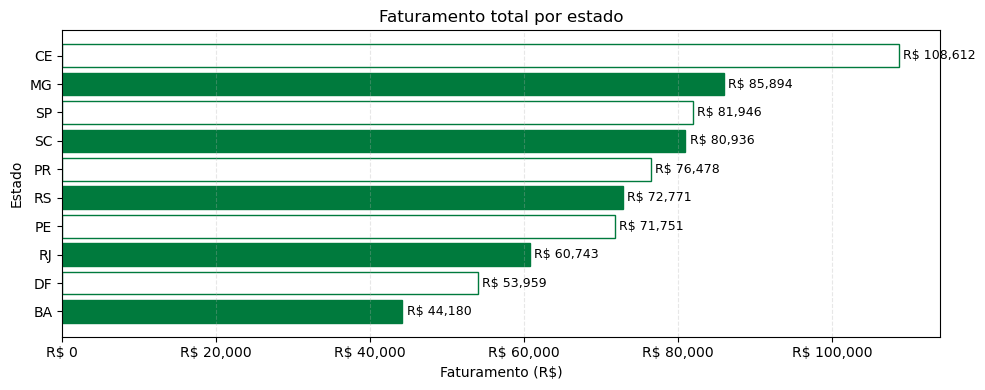

In [4]:
# Gráfico: faturamento total por estado (barras horizontais, cores Ceará: verde e branco)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pathlib import Path

# Requer que o DataFrame `df` já exista (execute a célula que carrega o CSV primeiro)
if 'df' not in globals():
    raise NameError("DataFrame 'df' não encontrado. Execute a célula que carrega o CSV primeiro.")

# Funções utilitárias (redefinidas aqui para independência da ordem de execução)
def find_col(cols, candidates):
    cols_list = list(cols)
    cols_lower = [str(c).lower() for c in cols_list]
    for pat in candidates:
        for i, c in enumerate(cols_lower):
            if pat in c:
                return cols_list[i]
    return None

def parse_amount(series: pd.Series) -> pd.Series:
    s = series.astype(str).fillna('')
    s = s.str.replace(r"[^0-9,.\-]", "", regex=True)
    mask = s.str.contains(',') & s.str.contains('\.')
    s.loc[mask] = s.loc[mask].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    s.loc[~mask] = s.loc[~mask].str.replace(',', '.', regex=False)
    s = s.replace('', pd.NA)
    return pd.to_numeric(s, errors='coerce')

# Detecta colunas (ajuste manual se necessário)
state_col = find_col(df.columns, ['estado', 'state', 'uf'])
amount_col = find_col(df.columns, ['faturamento', 'valor_total', 'valor', 'total', 'amount', 'preco', 'price', 'valor_final', 'valor_pago'])

if state_col is None or amount_col is None:
    print('Colunas disponíveis:', list(df.columns))
    raise KeyError('Não foi possível identificar automaticamente as colunas de estado e/ou valor. Ajuste `state_col` e `amount_col` manualmente.')

# Calcula faturamento por estado (numérico)
df['_amount_num'] = parse_amount(df[amount_col])
state_totals = df.groupby(state_col)['_amount_num'].sum()
state_totals = state_totals.dropna().sort_values()  # do menor ao maior para barh

# Configurações do gráfico (cores do Ceará: verde e branco)
ceara_green = '#007A3D'  # tom de verde usado como referência
n = len(state_totals)
# Alterna entre verde e branco para as barras
colors = [ceara_green if i % 2 == 0 else 'white' for i in range(n)]

plt.figure(figsize=(10, max(4, 0.35 * n)))
bars = plt.barh(state_totals.index, state_totals.values, color=colors, edgecolor=ceara_green)

# Formatação do eixo X (R$ com separador de milhares)
def fmt(x, pos):
    return f"R$ {x:,.0f}"

plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(fmt))
plt.xlabel('Faturamento (R$)')
plt.ylabel('Estado')
plt.title('Faturamento total por estado')
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Anota valores ao final das barras
for bar, val in zip(bars, state_totals.values):
    x = bar.get_width()
    plt.text(x + max(state_totals.values) * 0.005, bar.get_y() + bar.get_height()/2,
             f"R$ {val:,.0f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [3]:
df = pd.read_csv(Path("Relatório de Compras.excel.csv"), sep=';', engine='python', encoding='latin1')

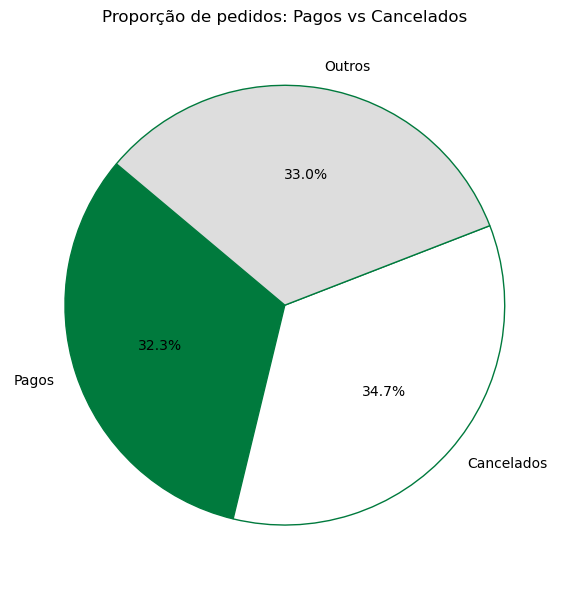

In [5]:
# Gráfico de pizza: proporção de pedidos pagos x cancelados
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Carrega df se necessário
file = Path('Relatório de Compras.excel.csv')
if 'df' not in globals():
    if not file.exists():
        raise FileNotFoundError(f'Arquivo não encontrado: {file.resolve()}')
    try:
        df = pd.read_csv(file, sep=None, engine='python', encoding='utf-8')
    except Exception:
        df = pd.read_csv(file, sep=';', engine='python', encoding='latin1')

# Detecta coluna de status/pagamento
def find_col(cols, candidates):
    cols_list = list(cols)
    cols_lower = [str(c).lower() for c in cols_list]
    for pat in candidates:
        for i, c in enumerate(cols_lower):
            if pat in c:
                return cols_list[i]
    return None

status_col = find_col(df.columns, ['status','situacao','situação','estado','status_pedido','status_pagamento','payment_status','payment'])
if status_col is None:
    print('Colunas disponíveis:', list(df.columns))
    raise KeyError('Não foi possível detectar a coluna de status. Ajuste manualmente.')

vals = df[status_col].astype(str).fillna('').str.lower().str.strip()
paid_patterns = ['pago','paid','concluido','concluído','completed','success','autorizado','authorized']
cancel_patterns = ['cancel','cancelado','cancelled','void','estornado','reembolsado','refunded']

def map_status(s):
    for p in cancel_patterns:
        if p in s:
            return 'Cancelado'
    for p in paid_patterns:
        if p in s:
            return 'Pago'
    return 'Outro'

mapped = vals.map(map_status)
counts = mapped.value_counts().reindex(['Pago','Cancelado','Outro'], fill_value=0)

# Monta fatias
labels = []
sizes = []
if counts['Pago'] > 0:
    labels.append('Pagos')
    sizes.append(counts['Pago'])
if counts['Cancelado'] > 0:
    labels.append('Cancelados')
    sizes.append(counts['Cancelado'])
if counts['Outro'] > 0:
    labels.append('Outros')
    sizes.append(counts['Outro'])

if sum(sizes) == 0:
    raise ValueError('Nenhum status detectado. Verifique a coluna de status.')

# Cores Ceará: verde e branco
ceara_green = '#007A3D'
colors = []
for lab in labels:
    if lab == 'Pagos':
        colors.append(ceara_green)
    elif lab == 'Cancelados':
        colors.append('white')
    else:
        colors.append('#dddddd')

plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct=lambda p: f'{p:.1f}%', startangle=140, wedgeprops={'edgecolor':ceara_green})
plt.title('Proporção de pedidos: Pagos vs Cancelados')
for t in texts + autotexts:
    t.set_color('black')
plt.tight_layout()
plt.show()
